In [ ]:
import trajectory_manifold.estimation as estimation
import trajectory_manifold.examples as examples
from trajectory_manifold.manifold import SolverParameters
from trajectory_manifold.manifold import system_pushforward_weight

from math import pi

import matplotlib.pyplot as plt
from diffrax import Tsit5, ODETerm, SaveAt, PIDController, diffeqsolve, Kvaerno5, Heun
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import numpy as onp
import jax.lax as lax

from tqdm import tqdm


# Setup Problem Specification

In [ ]:
vector_field = examples.lotka_volterra_vector_field(1,2,4,2)
noise_std = 1

center = 1.2

In [ ]:
parameters = SolverParameters(relative_tolerance = 1e-2,
                              absolute_tolerance = 1e-2,
                              step_size = 0.1,
                              time_interval = (0,10),
                              solver=Heun(),
                              max_steps=16**5)

# Compute Trajectory Weight Grid

In [ ]:
delta = 0.05
x = y = jnp.arange(center - 1, center + 1 + delta, delta)
X, Y = jnp.meshgrid(x, y)
samples = jnp.stack([X.flatten(), Y.flatten()])

In [ ]:
lotka_weight = lambda state: system_pushforward_weight(vector_field, parameters.time_interval, state)
lotka_weight = jit(lotka_weight)
vec_lotka_weight = vmap(lotka_weight, 1)
vec_lotka_weight = jit(vec_lotka_weight)

In [ ]:
weight_matrix = onp.zeros(samples.shape[1])
chunk_size = 5
for i in tqdm(range(samples.shape[1]//chunk_size)):
    weight_matrix[i*chunk_size:(i+1)*chunk_size] = vec_lotka_weight(samples[:,i*chunk_size:(i+1)*chunk_size])
start = chunk_size * (samples.shape[1]//chunk_size)
weight_matrix[start:] = vec_lotka_weight(samples[:, start:])


In [ ]:
plt.contourf(x,y, onp.reciprocal(onp.reshape(weight_matrix, (x.shape[0], y.shape[0]))))

In [ ]:
plt.imshow(onp.reciprocal(onp.reshape(weight_matrix, (x.shape[0], y.shape[0]))), extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', interpolation='bilinear')
plt.colorbar()

# Simulate Observations

In [585]:
key = random.PRNGKey(123)
key, subkey = random.split(key)
true_init = 2 * random.uniform(subkey, shape=(2,)) + center - 1

In [586]:
term = ODETerm(vector_field)
solver = parameters.solver
observation_times = jnp.arange(parameters.time_interval[0], 
                               parameters.time_interval[1] + parameters.step_size, 
                               step=parameters.step_size)

saveat = SaveAt(ts = observation_times)

stepsize_controller = PIDController(rtol = parameters.relative_tolerance,
                                    atol = parameters.absolute_tolerance)
        
states = diffeqsolve(term,
                     solver,
                     t0 = parameters.time_interval[0],
                     t1 = parameters.time_interval[1],
                     dt0 = parameters.step_size,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = true_init).ys


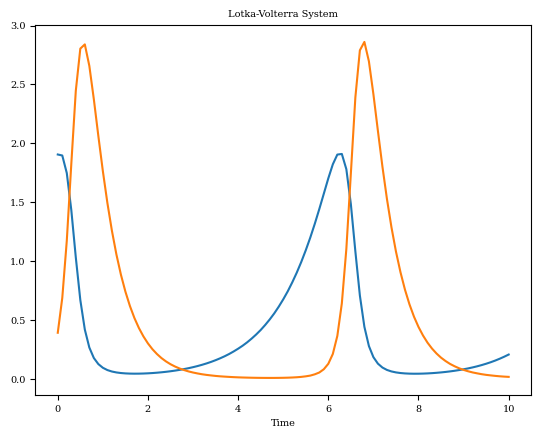

In [587]:
plt.plot(observation_times, states);
plt.xlabel("Time");
plt.title("Lotka-Volterra System");

In [588]:
key, subkey = random.split(key)
noise = noise_std*random.normal(subkey, shape=states.shape)
observations = states + noise
observation_times = observation_times[:30]
observations = observations[:30,:]
subsample = 3

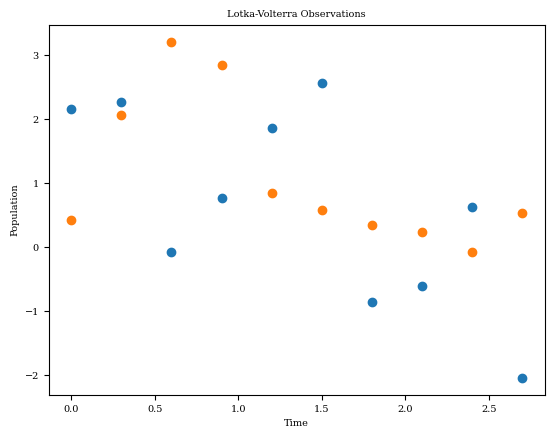

In [589]:
plt.scatter(observation_times[::subsample], observations[::subsample,0]);
plt.scatter(observation_times[::subsample], observations[::subsample,1]);

plt.title("Lotka-Volterra Observations")
plt.xlabel("Time")
plt.ylabel("Population");

# Compute Estimation Functions

In [590]:
def observation_log_likelihood(observation, state):
    partition = jnp.power(2 * pi, -observations.shape[1]/2.0)
    return jnp.log(partition) -1 * jnp.sum(jnp.square(observation - state))/(2*noise_std**2)

In [591]:
def state_log_prior(state):
    return -1 * jnp.log(9)
    #partition = jnp.power(2 * pi, -observations.shape[1]/2.0)
    #return jnp.log(partition) -1 * jnp.sum(jnp.square(state - 3))/2

In [592]:
log_likelihood = estimation.trajectory_log_likelihood(vector_field,
                                                       observations[::subsample],
                                                       observation_times[::subsample], 
                                                       observation_log_likelihood,
                                                       parameters)

log_posterior_state = estimation.state_log_posterior(vector_field,
                                                     observations[::subsample],
                                                     observation_times[::subsample], 
                                                     observation_log_likelihood,
                                                     state_log_prior,
                                                     parameters)

log_posterior_trajectory = estimation.trajectory_log_posterior(vector_field,
                                                     observations[::subsample],
                                                     observation_times[::subsample], 
                                                     observation_log_likelihood,
                                                     state_log_prior,
                                                     (0,10),
                                                     parameters)

In [593]:
v_ll = vmap(log_likelihood)
v_ps = vmap(log_posterior_state)

def v_pt(initial_condition):
    out = jnp.zeros(initial_condition.shape[0])
    
    @jit
    def inner(i, out):
        init = initial_condition[i,:]
        out = out.at[i].set(log_posterior_trajectory(init))
        return out
    return lax.fori_loop(0,initial_condition.shape[0], inner, out)

In [594]:
grid_ll = v_ll(samples.T)
grid_ps = v_ps(samples.T)
#grid_pt = v_pt(samples.T)
grid_pt = grid_ps - jnp.log(jnp.array(weight_matrix))

In [595]:
grid_ll = jnp.reshape(grid_ll, (x.shape[0], y.shape[0]))
grid_ps = jnp.reshape(grid_ps, (x.shape[0], y.shape[0]))
grid_pt = jnp.reshape(grid_pt, (x.shape[0], y.shape[0]))

In [596]:
posterior_trajectory = jnp.exp(grid_pt)/jnp.sum(jnp.exp(grid_pt))/(delta**2)
posterior_state = jnp.exp(grid_ps)/jnp.sum(jnp.exp(grid_ps))/(delta**2)

In [597]:
@jit
def SolveODE(initial_state):
    return diffeqsolve(term,
                     solver,
                     t0 = parameters.time_interval[0],
                     t1 = parameters.time_interval[1],
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = initial_state).ys

In [598]:
solveODE_v = vmap(SolveODE)
solution_set = solveODE_v(samples.T)
solution_set = jnp.reshape(solution_set, (posterior_trajectory.shape[0],posterior_trajectory.shape[1],solution_set.shape[1],2))

In [599]:
samples

Array([[0.2      , 0.25     , 0.3      , ..., 2.1      , 2.1499999,
        2.1999998],
       [0.2      , 0.2      , 0.2      , ..., 2.1999998, 2.1999998,
        2.1999998]], dtype=float32)

In [600]:
def square_distance_tensor(solution_set):
    tensor_shape = (solution_set.shape[0],
                    solution_set.shape[1],
                    solution_set.shape[0],
                    solution_set.shape[1])
    out = jnp.zeros(tensor_shape)
    for i in range(solution_set.shape[0]):
        for j in range(solution_set.shape[1]):
            solution = solution_set[i,j,:,:]
            distance_mat = jnp.sum(jnp.square(solution[None, None, :, :] - solution_set), axis=(2,3)) * parameters.step_size
            out = out.at[i,j,:,:].set(distance_mat)
    return out

In [601]:
def mse_with_distance(density, distance_mat):
    out = jnp.zeros_like(density)
    for i in range(distance_mat.shape[2]):
        for j in range(distance_mat.shape[3]):
            out = out.at[i,j].set(jnp.sum(density[None, None, :, :] * distance_mat[:,:,i,j]))
    return out*(delta**2)

In [602]:
peak_ll = jnp.argmax(grid_ll)
peak_x_ll = x[peak_ll % x.shape[0]]
peak_y_ll = y[peak_ll // x.shape[0]]
ml_est = jnp.stack([peak_x_ll, peak_y_ll])

peak_ps = jnp.argmax(grid_ps)
peak_x_ps = x[peak_ps % x.shape[0]]
peak_y_ps = y[peak_ps // x.shape[0]]
map_state_est = jnp.stack([peak_x_ps, peak_y_ps])

peak_pt = jnp.argmax(grid_pt)
peak_x_pt = x[peak_pt % x.shape[0]]
peak_y_pt = y[peak_pt // x.shape[0]]
map_traj_est = jnp.stack([peak_x_pt, peak_y_pt])

distance_mat = square_distance_tensor(solution_set)
mse_mat = mse_with_distance(posterior_state, distance_mat)
peak_mse = jnp.argmin(mse_mat)
peak_x_mse = x[peak_mse % x.shape[0]]
peak_y_mse = y[peak_mse // x.shape[0]]
mse_traj_est = jnp.stack([peak_x_mse, peak_y_mse])



# Generate Plots

In [681]:
# Generate MSE for state plot
initial_condition_mat = jnp.reshape(samples,(2,posterior_state.shape[0], posterior_state.shape[1]))
mse_state = onp.zeros_like(posterior_state)
for i in range(posterior_state.shape[0]):
    for j in range(posterior_state.shape[1]):
        errors = jnp.square(jnp.linalg.norm(initial_condition_mat - initial_condition_mat[:,i,j][:, None, None], axis=0))
        mse_state[i,j] = jnp.sum(errors * posterior_state)*delta**2

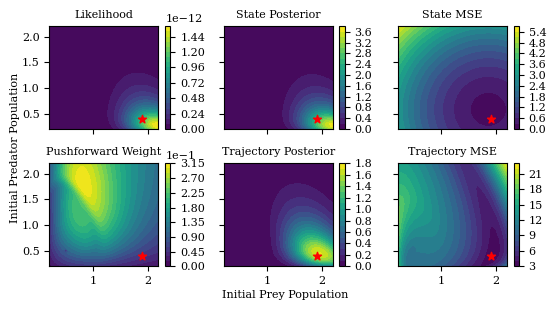

In [682]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True)
im = axs[0,0].contourf(x,y, jnp.exp(grid_ll), levels=20)
#axs[0,0].scatter([peak_x_ll],[peak_y_ll])
axs[0,0].set_title("Likelihood");
cb = plt.colorbar(im)
cb.ax.yaxis.set_offset_position('left')

im = axs[0,1].contourf(x,y, posterior_state, levels=20)
#axs[0,1].scatter([peak_x_ps],[peak_y_ps])
axs[0,1].set_title("State Posterior");
plt.colorbar(im)

im = axs[0,2].contourf(x,y, mse_state, levels=20)
#axs[0,2].scatter([initial_condition_mmse[0]],[initial_condition_mmse[1]])
axs[0,2].set_title("State MSE");
plt.colorbar(im)

im = axs[1,2].contourf(x,y, mse_mat, levels=20)
#axs[1,2].scatter([peak_x_mse],[peak_y_mse])
axs[1,2].set_title("Trajectory MSE");
plt.colorbar(im)

im = axs[1,1].contourf(x,y, posterior_trajectory, levels=20)
#axs[1,1].scatter([peak_x_pt],[peak_y_pt])
axs[1,1].set_title("Trajectory Posterior");
plt.colorbar(im)

im = axs[1,0].contourf(x,y, jnp.reciprocal(jnp.reshape(weight_matrix,(x.shape[0],y.shape[0]))), levels=20)
axs[1,0].set_title("Pushforward Weight");
cb = plt.colorbar(im)
cb.formatter.set_powerlimits((0,0))
cb.ax.yaxis.set_offset_position('left')


for i in range(2):
    for j in range(3):
        axs[i,j].scatter([true_init[0]],[true_init[1]], marker='*', color='red')
        #axs[i,j].set(xlabel="Prey Population", ylabel="Predator Population")
fig.text(0.5, 0.0, "Initial Prey Population", ha='center')
fig.text(0.0, 0.5, "Initial Predator Population", va='center', rotation='vertical')
fig.set_figheight(3)
fig.set_figwidth(5.5)
fig.tight_layout()

In [683]:
fig.savefig("objectives.pdf", format="pdf", bbox_inches="tight")

In [678]:
timesteps = jnp.arange(parameters.time_interval[0], 
                               parameters.time_interval[1] + parameters.step_size, 
                               step=parameters.step_size)

true_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = true_init).ys

ml_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = ml_est).ys

map_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = map_state_est).ys

map_traject_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = map_traj_est).ys

mmse_ambient_est_traject = jnp.sum(posterior_state[:,:,None, None] * solution_set, axis=(0,1))*delta**2

mmse_manifold_est_traject = SolveODE(mse_traj_est)

initial_condition_mmse = jnp.sum(posterior_state[:,:,None] * jnp.reshape(samples.T, (posterior_trajectory.shape[0],posterior_trajectory.shape[1],2)), axis=(0,1))*delta**2
init_mmse_traject = SolveODE(initial_condition_mmse)

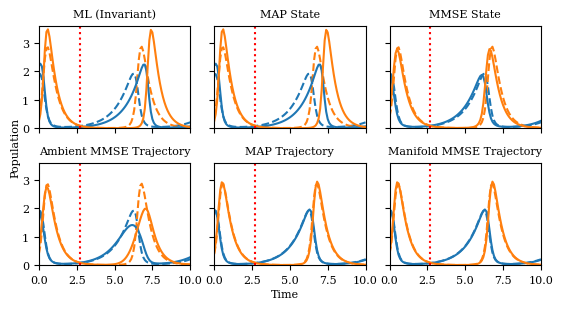

In [679]:
SMALL_SIZE = 8
MEDIUM_SIZE = SMALL_SIZE
BIGGER_SIZE = SMALL_SIZE
plt.rc('font', size=SMALL_SIZE, family="DejaVu Serif")          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axs = plt.subplots(2,3, sharex=True, sharey=True)

axs[0,0].plot(timesteps, true_traject, linestyle="--")
axs[0,0].set_prop_cycle(None)
axs[0,0].plot(timesteps, ml_est_traject)
axs[0,0].set_title("ML (Invariant)")


axs[0,1].plot(timesteps, true_traject, linestyle="--")
axs[0,1].set_prop_cycle(None)
axs[0,1].plot(timesteps, map_est_traject)
axs[0,1].set_title("MAP State")



axs[1,1].plot(timesteps, true_traject, linestyle="--")
axs[1,1].set_prop_cycle(None)
axs[1,1].plot(timesteps, map_traject_est_traject)
axs[1,1].set_title("MAP Trajectory")



axs[1,0].plot(timesteps, true_traject, linestyle="--")
axs[1,0].set_prop_cycle(None)
axs[1,0].plot(timesteps, mmse_ambient_est_traject)
axs[1,0].set_title("Ambient MMSE Trajectory")

axs[0,2].plot(timesteps, true_traject, linestyle="--")
axs[0,2].set_prop_cycle(None)
axs[0,2].plot(timesteps, init_mmse_traject)
axs[0,2].set_title("MMSE State")


axs[1,2].plot(timesteps, true_traject, linestyle="--")
axs[1,2].set_prop_cycle(None)
axs[1,2].plot(timesteps, mmse_manifold_est_traject)
axs[1,2].set_title("Manifold MMSE Trajectory")

for i in range(2):
    for j in range(3):
        vline = axs[i,j].axvline(x=observation_times[::subsample][-1], linestyle="dotted", color="red")
        axs[i,j].set_xlim(0,10)
        axs[i,j].set_ylim(0,3.6)

fig.text(0.5,0, "Time", ha='center')
fig.text(0,0.5,"Population",va='center', rotation='vertical')
fig.set_figwidth(5.5)
fig.set_figheight(3)
fig.tight_layout()

In [680]:
fig.savefig("forecast_lotka.pdf", format="pdf", bbox_inches="tight")